In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

# Read Data

In [2]:
data = pkl.load(open('demodata.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x_train_max = data['x_train_max']

In [3]:
print('X_input_train', X_input_train.shape, 
          'X_output_train', X_output_train.shape, 
          'X_input_test', X_input_test.shape, 
          'X_output_test', X_output_test.shape, 
          'x_train_max', x_train_max.shape)

X_input_train (1413, 49, 82) X_output_train (1413, 21, 2) X_input_test (346, 49, 82) X_output_test (346, 21, 2) x_train_max (83,)


# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/Luong%20Attention.png?raw=true)

In [4]:
X_input_train.shape, X_output_train.shape

((1413, 49, 82), (1413, 21, 2))

In [5]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 49, 81), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [6]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 49, 100), dtype=tf.float32, name=None), name='lstm/transpose_1:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [7]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [8]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [9]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [10]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [11]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 49), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


In [12]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


In [13]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [14]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [15]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 81)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 49, 100), (N 72800       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 21, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

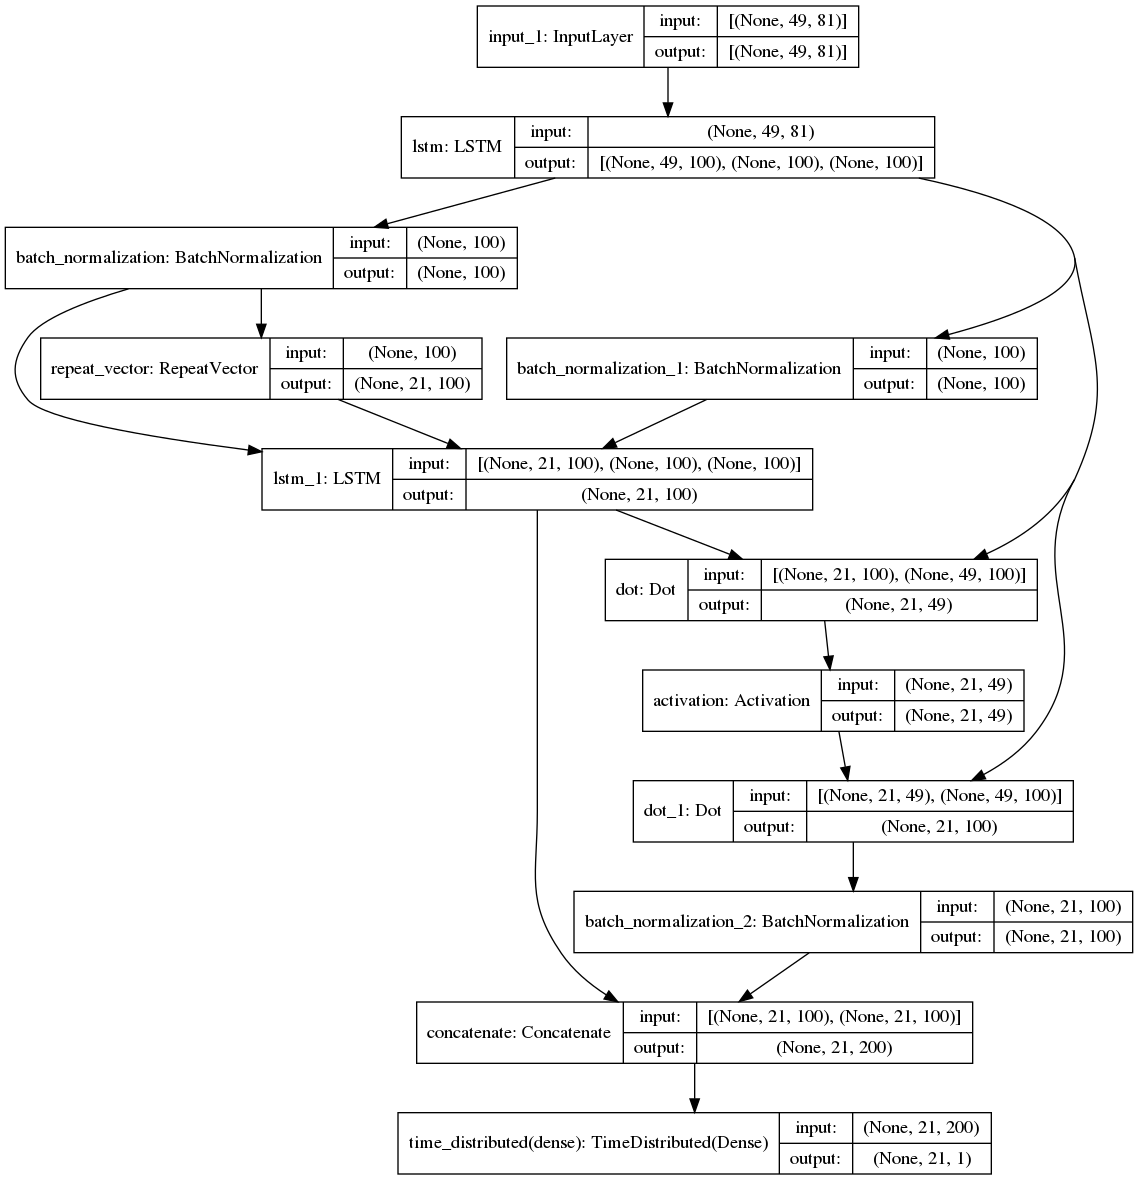

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
display(X_input_train.shape, X_output_train.shape)

(1413, 49, 82)

(1413, 21, 2)

In [18]:
array_sum = np.sum(X_input_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [19]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
model.load_weights('Forecasting_seq2seq_attention.h5')
history = model.fit(X_input_train[:, :, :-1], X_output_train[:, :, :-1], validation_split=0.2, 
                    epochs=epc, verbose=1,
                    callbacks=[es], 
                    batch_size=1000)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('Forecasting_seq2seq_attention.h5')

Epoch 1/100
2/2 [==============================] - 5s 756ms/step - loss: 0.0020 - mae: 0.0278 - val_loss: 0.0143 - val_mae: 0.0970
Epoch 2/100
2/2 [==============================] - 1s 156ms/step - loss: 0.0045 - mae: 0.0458 - val_loss: 0.0059 - val_mae: 0.0720
Epoch 3/100
2/2 [==============================] - 1s 157ms/step - loss: 0.0064 - mae: 0.0555 - val_loss: 9.1773e-04 - val_mae: 0.0255
Epoch 4/100
2/2 [==============================] - 1s 141ms/step - loss: 0.0038 - mae: 0.0395 - val_loss: 0.0024 - val_mae: 0.0439
Epoch 5/100
2/2 [==============================] - 1s 152ms/step - loss: 0.0032 - mae: 0.0395 - val_loss: 6.9127e-04 - val_mae: 0.0204
Epoch 6/100
2/2 [==============================] - 1s 152ms/step - loss: 0.0021 - mae: 0.0311 - val_loss: 8.7970e-04 - val_mae: 0.0228
Epoch 7/100
2/2 [==============================] - 1s 143ms/step - loss: 0.0026 - mae: 0.0336 - val_loss: 9.4978e-04 - val_mae: 0.0259
Epoch 8/100
2/2 [==============================] - 1s 151ms/step - 

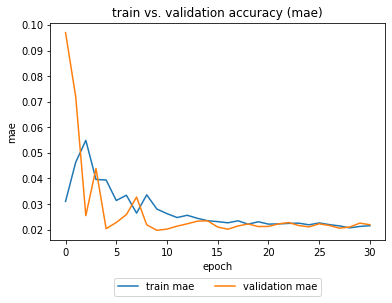

In [20]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [21]:
train_pred_detrend = model.predict(X_input_train[:, :, :-1])*x_train_max[:-1]
test_pred_detrend = model.predict(X_input_test[:, :, :-1])*x_train_max[:-1]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :-1]*x_train_max[:-1]
test_true_detrend = X_output_test[:, :, :-1]*x_train_max[:-1]
print(train_true_detrend.shape, test_true_detrend.shape)

(1413, 21, 82) (346, 21, 82)
(1413, 21, 82) (346, 21, 82)


In [22]:
#Time to add the index again
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, -1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, -1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, -1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, -1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(1413, 21, 83) (346, 21, 83)
(1413, 21, 83) (346, 21, 83)


In [23]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0]
    dt_x2 = dt[:, :, 1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (1413, 21, 2)
train_true: (1413, 21, 2)
test_pred: (346, 21, 2)
test_true: (346, 21, 2)


In [24]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
27.195779839754106
maximum: train_true
71.017536
maximum: test_pred
27.160004555583
maximum: test_true
83.470848


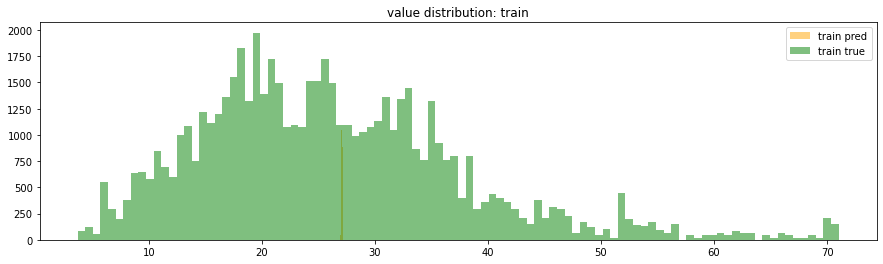

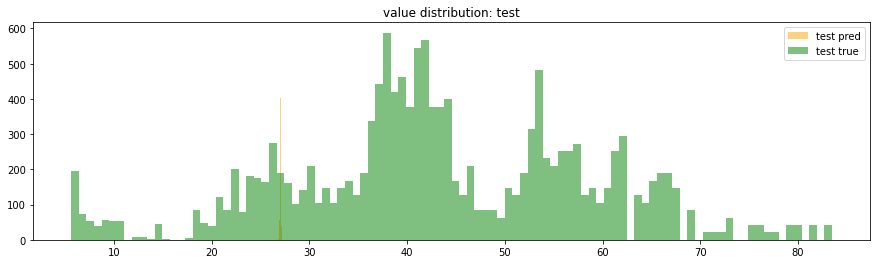

In [25]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

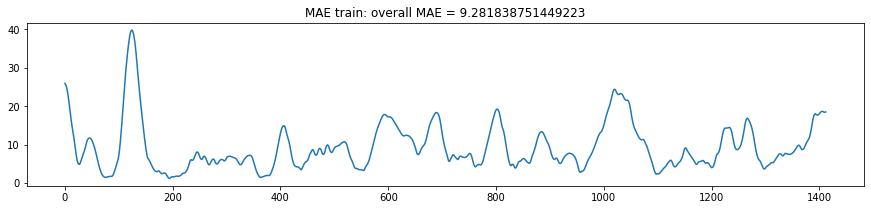

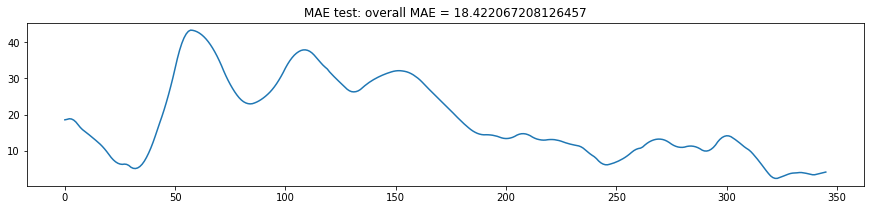

In [26]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

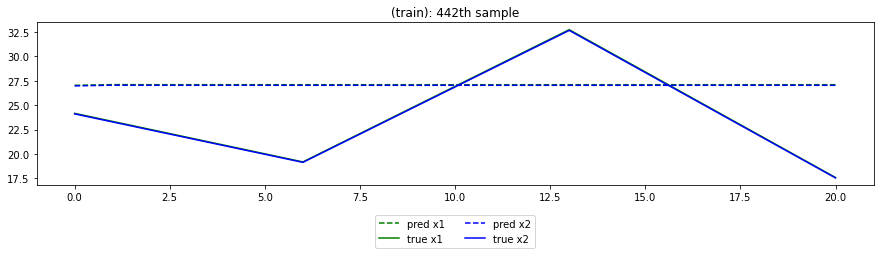

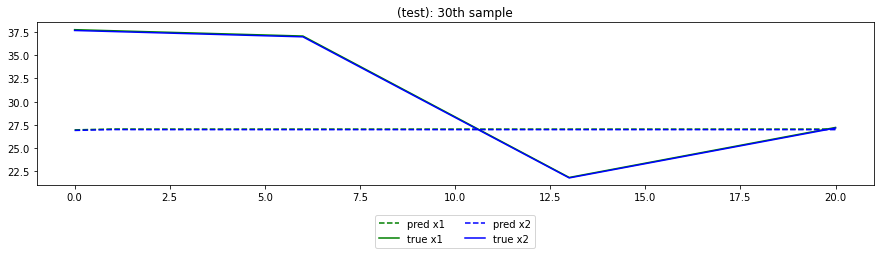

In [27]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))
    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

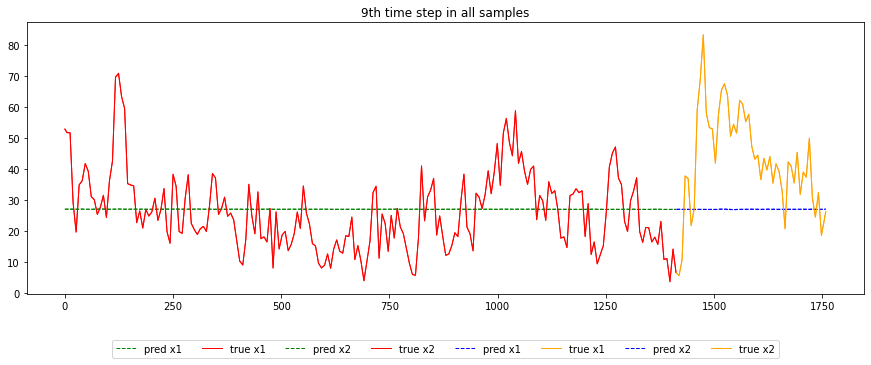

In [28]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

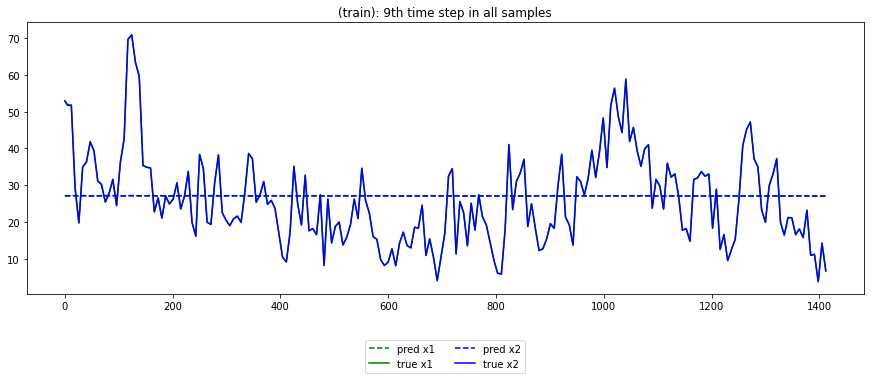

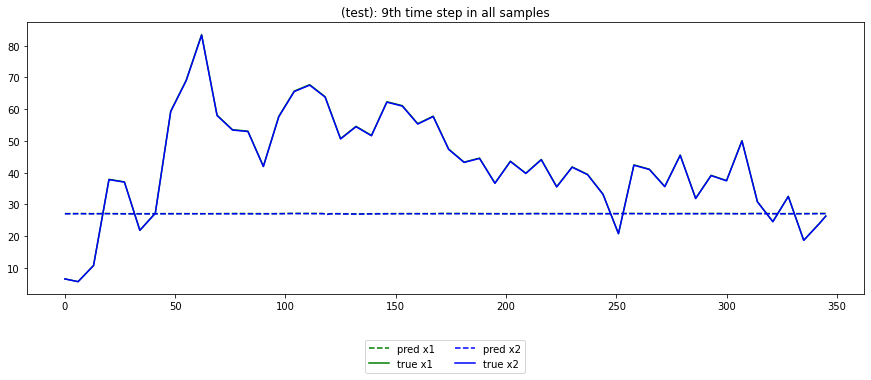

In [29]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()
